# Set-up

In [1]:
%%capture
# Install top2vec and transformers
!pip install top2vec transformers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# text processing stuff
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from transformers import pipeline
# Now proceed with TF-IDF and NMF as originally planned
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# topic modelling
from top2vec import Top2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [3]:
# Read the Excel file into a pandas DataFrame
df = pd.read_excel("raw_data.xlsx", sheet_name="T1 Raw Data")

In [4]:
df.head()

,CustomerID,Age,Gender,TotalPurchaseAmount
0,1,32,Male,150.25
1,2,45,Female,235.40
2,3,28,Male,80.15
3,4,39,Female,300.00
4,5,55,Other,180.75


### Finding grain of the data; EDA

In [5]:
# Check for duplicate CustomerIDs
duplicate_customer_ids = df[df.duplicated('CustomerID', keep=False)]
print(f"Number of duplicate CustomerIDs: {len(duplicate_customer_ids)}")

# Check if duplicated CustomerIDs have different Age values and print the count
duplicates_customer_age_count = (df.groupby('CustomerID')['Age'].nunique() > 1).sum()
print(f"\nNumber of CustomerIDs with duplicate entries and different Age values: {duplicates_customer_age_count}")

# Check if duplicated CustomerIDs have different Gender values and print the count
duplicates_customer_gender_count = (df.groupby('CustomerID')['Gender'].nunique() > 1).sum()
print(f"\nNumber of CustomerIDs with duplicate entries and different Gender values: {duplicates_customer_gender_count}")

# Check if duplicated CustomerIDs have different Age and Gender values and print the count
duplicates_customer_age_gender_count = (df.groupby('CustomerID')[['Age', 'Gender']].nunique().sum(axis=1) > 2).sum()
print(f"\nNumber of CustomerIDs with duplicate entries and different Age and Gender values: {duplicates_customer_age_gender_count}")

# Check if there are any duplicate rows across all columns
duplicates_all_columns = df[df.duplicated(keep=False)]
print(f"\nNumber of duplicate rows across all columns: {len(duplicates_all_columns)}")
display(duplicates_all_columns)

Number of duplicate CustomerIDs: 134

Number of CustomerIDs with duplicate entries and different Age values: 0

Number of CustomerIDs with duplicate entries and different Gender values: 0

Number of CustomerIDs with duplicate entries and different Age and Gender values: 0

Number of duplicate rows across all columns: 0


,CustomerID,Age,Gender,TotalPurchaseAmount


# TASK 1

###  Calculate the average age of customers separately for each gender category (Male,Female, Other).

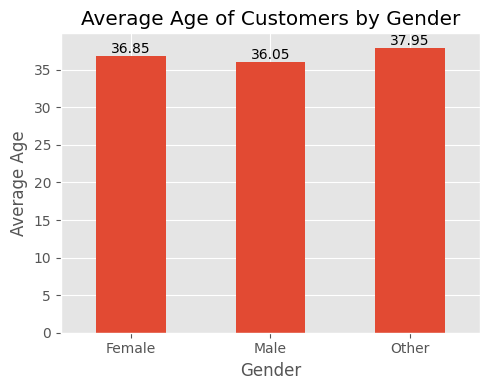

In [6]:
# Calculate the average age of customers separately for each gender category
average_age_by_gender = df.groupby('Gender')['Age'].mean()

# Create a bar chart
ax = average_age_by_gender.plot(kind='bar', figsize=(5, 4))

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average Age')
plt.title('Average Age of Customers by Gender')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


# Display the plot
plt.tight_layout()
plt.show()

### Identify the top 5 customers who have made the highest total purchase amount and display their information (CustomerID, Age, Gender, TotalPurchaseAmount).

In [7]:
# Group by CustomerID and sum the TotalPurchaseAmount
customer_purchase_summary = df.groupby('CustomerID')['TotalPurchaseAmount'].sum()

# Sort the customer purchase summary in descending order and select the top 5
top_5_customers = customer_purchase_summary.sort_values(ascending=False).head(5)

# Display the information of the top 5 customers
print("\nTop 5 customers with the highest total purchase amount (grouped by CustomerID):")
display(top_5_customers)


Top 5 customers with the highest total purchase amount (grouped by CustomerID):


,TotalPurchaseAmount
CustomerID,
19,1014.5
13,977.9
12,960.6
20,927.0
32,891.2


### Create a new DataFrame that contains the following information for each customer:

• CustomerID

• Age Category: Categorize customers into bins based on their
age (e.g., 18-25, 26-35, 36-45, etc.).

• PurchaseCount: The number of times a customer made a
purchase.

• TotalPurchaseAmount: The total amount spent by the
customer.

• AveragePurchaseAmount: The average amount spent by the
customer in each purchase.

In [8]:
# Define age bins and labels
age_bins = [0, 18, 25, 35, 45, 55, 65, float('inf')]
age_labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Create Age Category column
df['Age Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Group by CustomerID to calculate PurchaseCount, TotalPurchaseAmount, and AveragePurchaseAmount
customer_summary = df.groupby('CustomerID').agg(
    Age=('Age', 'first'), # Keep the first age for each customer
    Gender=('Gender', 'first'), # Keep the first gender for each customer
    PurchaseCount=('TotalPurchaseAmount', 'count'),
    TotalPurchaseAmount=('TotalPurchaseAmount', 'sum'),
    AveragePurchaseAmount=('TotalPurchaseAmount', 'mean')
).reset_index()

# Merge with Age Category
customer_summary = pd.merge(customer_summary, df[['CustomerID', 'Age Category']].drop_duplicates(), on='CustomerID')

# Reorder columns
customer_summary = customer_summary[['CustomerID', 'Age Category', 'PurchaseCount', 'TotalPurchaseAmount', 'AveragePurchaseAmount']]

# Display the new DataFrame
display(customer_summary.head())

,CustomerID,Age Category,PurchaseCount,TotalPurchaseAmount,AveragePurchaseAmount
0,1,26-35,2,413.25,206.625
1,2,46-55,2,679.40,339.700
2,3,26-35,2,255.15,127.575
3,4,36-45,2,455.00,227.500
4,5,56-65,2,490.75,245.375


In [9]:
# Save the customer_summary DataFrame to an Excel file
customer_summary.to_excel("customer_summary.xlsx", index=False, header=True)

print("customer_summary.xlsx file has been created successfully.")

customer_summary.xlsx file has been created successfully.


# TASK 2


Analyze customer reviews from the "T2 Customer Reviews" sheet in "raw_data.xlsx" to understand sentiments, emotions, key topics, and sub-topics. Save the results to "customer_feedback_cluster.xlsx" and provide a summary of the findings. Use any suitable strategy, including pre-trained models, GEN AI, or traditional machine learning. "raw_data.xlsx"

### Pre-requisites

In [10]:
df_reviews = pd.read_excel("raw_data.xlsx", sheet_name="T2 Customer Reviews")
display(df_reviews.head())
display(df_reviews.info())

,uniq_id,review
0,1,this is the most vile mix ever don't waste you...
1,2,"i actually love the taste of this bacon, it re..."
2,3,"generous sized steak, nicely flavoured, fell a..."
3,4,"an absolutely delicious sausage, with a good k..."
4,5,superb tender aromatic duck comes with pancake...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   uniq_id  1499 non-null   int64 
 1   review   1499 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


None

In [11]:
df_reviews.uniq_id.nunique()

1499

### Subtask 1 - Sentiment analysis

Your task is to analyse the reviews provided by the customers and help
us understand the following: Sentiments (and if possible emotions analysis as well)

In [12]:
#### Preprocessing #####

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Cleans the text data."""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) # Apply lemmatization
    return text

df_reviews['cleaned_review'] = df_reviews['review'].apply(preprocess_text)

display(df_reviews.head())

,uniq_id,review,cleaned_review
0,1,this is the most vile mix ever don't waste you...,vile mix ever dont waste money
1,2,"i actually love the taste of this bacon, it re...",actually love taste bacon reminds bacon child ...
2,3,"generous sized steak, nicely flavoured, fell a...",generous sized steak nicely flavoured fell apa...
3,4,"an absolutely delicious sausage, with a good k...",absolutely delicious sausage good kick chilli ...
4,5,superb tender aromatic duck comes with pancake...,superb tender aromatic duck come pancake place...


In [13]:
##### Sentiment analysis.  #######

# Use a pre-trained model or library to determine the sentiment of each review (e.g., positive, negative, neutral).
# Import the SentimentIntensityAnalyzer, download the vader lexicon, initialize the analyzer, apply it to the 'cleaned_review' column
# determine the sentiment label based on the compound score, and display the head of the dataframe.

# Download the VADER lexicon
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError: # Changed from nltk.downloader.DownloadError
    nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment label from VADER compound score
def get_vader_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis and get the compound score
df_reviews['compound_score'] = df_reviews['cleaned_review'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Get the sentiment label based on the compound score
df_reviews['sentiment'] = df_reviews['compound_score'].apply(get_vader_sentiment)

# Display the head of the DataFrame with the new columns
display(df_reviews.head())

,uniq_id,review,cleaned_review,compound_score,sentiment
0,1,this is the most vile mix ever don't waste you...,vile mix ever dont waste money,-0.4153,Negative
1,2,"i actually love the taste of this bacon, it re...",actually love taste bacon reminds bacon child ...,0.9063,Positive
2,3,"generous sized steak, nicely flavoured, fell a...",generous sized steak nicely flavoured fell apa...,0.8613,Positive
3,4,"an absolutely delicious sausage, with a good k...",absolutely delicious sausage good kick chilli ...,0.5974,Positive
4,5,superb tender aromatic duck comes with pancake...,superb tender aromatic duck come pancake place...,0.9451,Positive


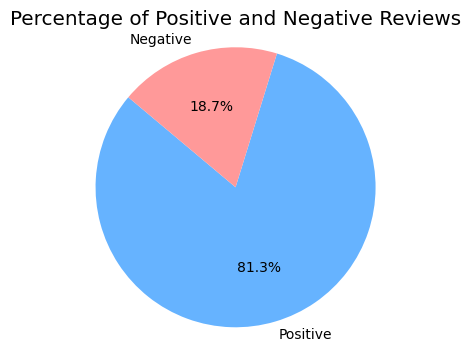

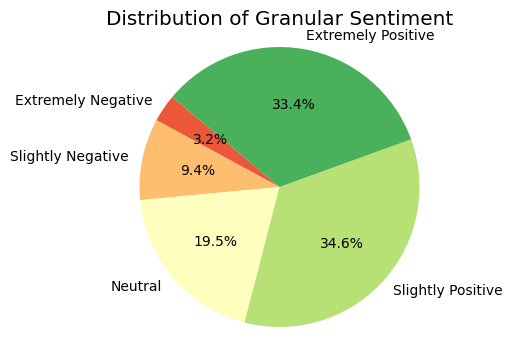

In [14]:
# 1) Pie chart showing % of positive and negative reviews

# Calculate the percentage of positive and negative reviews
sentiment_counts = df_reviews['sentiment'].value_counts(normalize=True) * 100

# Filter for only Positive and Negative sentiments for the first pie chart
sentiment_counts_binary = sentiment_counts[['Positive', 'Negative']]

plt.figure(figsize=(5, 4))
plt.pie(sentiment_counts_binary, labels=sentiment_counts_binary.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Percentage of Positive and Negative Reviews')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# 2) Percentage of reviews that are extremely positive, slightly positive, neutral, slightly negative, and extremely negative.

# Define thresholds for more granular sentiment categories based on compound score
def get_granular_sentiment(score):
    if score >= 0.7:
        return 'Extremely Positive'
    elif score >= 0.2:
        return 'Slightly Positive'
    elif score > -0.2 and score < 0.2:
        return 'Neutral'
    elif score <= -0.7:
        return 'Extremely Negative'
    elif score <= -0.2:
        return 'Slightly Negative'
    else:
        return 'Neutral' # Should not reach here with the above conditions, but as a fallback


df_reviews['granular_sentiment'] = df_reviews['compound_score'].apply(get_granular_sentiment)

# Calculate the percentage of each granular sentiment category
granular_sentiment_counts = df_reviews['granular_sentiment'].value_counts(normalize=True) * 100

# Ensure all categories are present for consistent plotting
granular_sentiment_order = ['Extremely Negative', 'Slightly Negative', 'Neutral', 'Slightly Positive', 'Extremely Positive']
granular_sentiment_counts = granular_sentiment_counts.reindex(granular_sentiment_order, fill_value=0)


plt.figure(figsize=(5, 4))
plt.pie(granular_sentiment_counts, labels=granular_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('RdYlGn', len(granular_sentiment_counts)))
plt.title('Distribution of Granular Sentiment')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

--- Analyzing Frequent Terms by Granular Sentiment Category ---

Analyzing 'Slightly Negative' reviews:


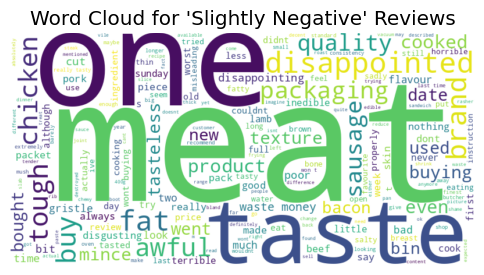

Top 5 most frequent words:


,0
meat,36
disappointed,23
taste,23
fat,22
brand,21


Top 5 most frequent bigrams:


,0
waste money,10
wont buying,5
really tasty,4
new packaging,4
last time,4



Analyzing 'Extremely Positive' reviews:


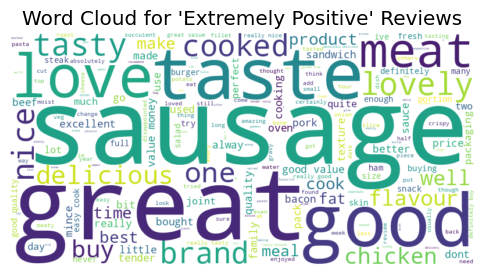

Top 5 most frequent words:


,0
good,176
great,125
sausage,113
tasty,107
taste,94


Top 5 most frequent bigrams:


,0
good value,40
value money,27
good quality,21
easy cook,19
really good,18



Analyzing 'Slightly Positive' reviews:


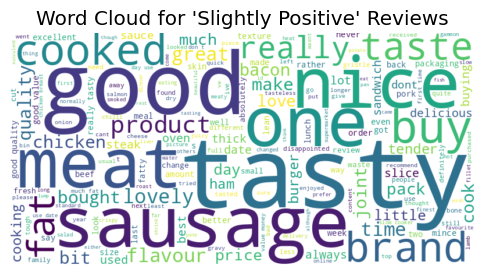

Top 5 most frequent words:


,0
tasty,112
good,107
sausage,69
nice,68
meat,66


Top 5 most frequent bigrams:


,0
good value,18
good quality,16
really tasty,14
value money,10
much fat,9



Analyzing 'Neutral' reviews:


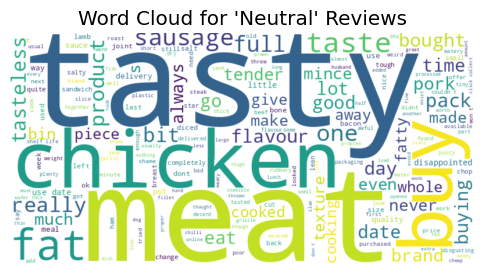

Top 5 most frequent words:


,0
tasty,50
meat,47
chicken,41
buy,37
fat,28


Top 5 most frequent bigrams:


,0
use date,10
would buy,6
really tasty,5
shelf life,5
always tasty,4



Analyzing 'Extremely Negative' reviews:


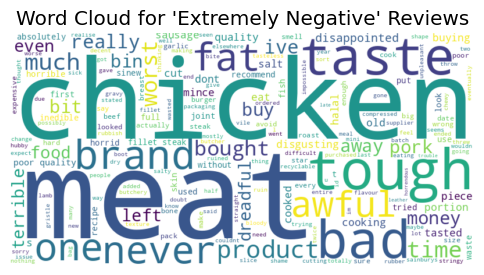

Top 5 most frequent words:


,0
meat,16
chicken,14
tough,13
taste,11
brand,11


Top 5 most frequent bigrams:


,0
poor quality,5
fillet steak,4
much fat,3
waste money,3
tough old,3



--- Analysis of Frequent Terms Complete ---


In [15]:
# Function to generate and display word cloud
def generate_wordcloud(text, title):
    if not text:
        print(f"No text available for Word Cloud: {title}")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Analyze frequent terms (words and bigrams) for each granular sentiment category
no_top_terms = 5 # Number of top terms to display

print("--- Analyzing Frequent Terms by Granular Sentiment Category ---")

# Define a list of additional stop words to remove
additional_stop_words = ['like', 'one'] # Add words you find uninsightful

# Combine with NLTK English stop words
custom_stop_words = set(stopwords.words('english')).union(set(additional_stop_words))


for sentiment_category in df_reviews['granular_sentiment'].unique():
    print(f"\nAnalyzing '{sentiment_category}' reviews:")

    # Filter reviews for the current granular sentiment category
    sentiment_reviews_df = df_reviews[df_reviews['granular_sentiment'] == sentiment_category]
    sentiment_text = " ".join(sentiment_reviews_df['cleaned_review'].tolist())

    if not sentiment_text:
        print("No reviews in this category.")
        continue

    # Generate and display word cloud
    generate_wordcloud(sentiment_text, f"Word Cloud for '{sentiment_category}' Reviews")

    # Calculate word frequencies using custom stop words
    count_vectorizer_words = CountVectorizer(stop_words=list(custom_stop_words))
    word_matrix = count_vectorizer_words.fit_transform(sentiment_reviews_df['cleaned_review'])
    word_counts = pd.DataFrame(word_matrix.sum(axis=0), columns=count_vectorizer_words.get_feature_names_out())

    # Get top N words
    top_words_sentiment = word_counts.T.sort_values(by=0, ascending=False).head(no_top_terms)
    print(f"Top {no_top_terms} most frequent words:")
    display(top_words_sentiment)

    # Calculate bigram frequencies using custom stop words
    count_vectorizer_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words=list(custom_stop_words))
    bigram_matrix = count_vectorizer_bigrams.fit_transform(sentiment_reviews_df['cleaned_review'])
    bigram_counts = pd.DataFrame(bigram_matrix.sum(axis=0), columns=count_vectorizer_bigrams.get_feature_names_out())

    # Get top N bigrams
    top_bigrams_sentiment = bigram_counts.T.sort_values(by=0, ascending=False).head(no_top_terms)
    print(f"Top {no_top_terms} most frequent bigrams:")
    display(top_bigrams_sentiment)

print("\n--- Analysis of Frequent Terms Complete ---")

#### Recommendations

Based on the detailed analysis, here is a concise summary of the key findings and recommendations.

The primary issues are with product quality, particularly for chicken products, which are causing the most severe negative feedback. Customers are consistently complaining about the toughness of the meat and excessive fat content. These quality failures are leading customers to feel they have wasted money.

Conversely, the brand's strengths lie in the taste, convenience, and perceived value for money of its products, especially with items like sausages.

1. Prioritize Fixing Chicken Product Quality: The most urgent action is to investigate and address the specific complaints of toughness in chicken products.  

2. Reduce Fat Content: Implement quality control measures to reduce the fat content, a consistent source of negative feedback across multiple products.

3. Leverage Your Strengths: Continue to market the products that customers love, such as sausages, by highlighting their great taste and convenience.

#### Emotion analysis

In [16]:
# Load a pre-trained model for emotion classification
emotion_pipeline = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=None)

emotion_columns = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'] # these are the emotions this model is trained to detect

# Function to get emotion scores based on model output labels
def get_emotion_scores(text):
    if not isinstance(text, str):
        # Return a dictionary with 0.0 for all expected emotion labels
        return {
            'sadness': 0.0,
            'joy': 0.0,
            'love': 0.0,
            'anger': 0.0,
            'fear': 0.0,
            'surprise': 0.0
        }

    # Analyze the emotion
    results = emotion_pipeline(text)

    # Create a dictionary with scores for each emotion label from the model output
    emotion_scores = {
        emotion_dict['label'].lower(): emotion_dict['score']
        for emotion_dict in results[0]
    }

    # Ensure all expected emotion labels are present in the dictionary, even if the score is 0.0
    expected_emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    for emotion in expected_emotions:
        if emotion not in emotion_scores:
            emotion_scores[emotion] = 0.0

    return emotion_scores

# Apply emotion analysis to the 'review' column
# Using the original 'review' column as the model might perform better on raw text
emotion_results = df_reviews['review'].apply(get_emotion_scores)

# Convert the results to a DataFrame and join with the original DataFrame
emotion_df = pd.DataFrame(list(emotion_results))

# Reset the index of df_reviews before concatenating to ensure a unique index
df_reviews = df_reviews.reset_index(drop=True)

df_reviews = pd.concat([df_reviews, emotion_df], axis=1)

print("Emotion analysis performed successfully using the model's direct output labels.")

# Display the head of the DataFrame with the new emotion columns
print(df_reviews.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


Emotion analysis performed successfully using the model's direct output labels.
   uniq_id                                             review  \
0        1  this is the most vile mix ever don't waste you...   
1        2  i actually love the taste of this bacon, it re...   
2        3  generous sized steak, nicely flavoured, fell a...   
3        4  an absolutely delicious sausage, with a good k...   
4        5  superb tender aromatic duck comes with pancake...   

                                      cleaned_review  compound_score  \
0                     vile mix ever dont waste money         -0.4153   
1  actually love taste bacon reminds bacon child ...          0.9063   
2  generous sized steak nicely flavoured fell apa...          0.8613   
3  absolutely delicious sausage good kick chilli ...          0.5974   
4  superb tender aromatic duck come pancake place...          0.9451   

  sentiment  granular_sentiment     anger   sadness      fear      love  \
0  Negative   Slightl

##### Descriptive Statistics of Emotion Scores

In [17]:
# Calculate descriptive statistics for the emotion scores
emotion_stats = df_reviews[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].describe()

print("Descriptive Statistics for Emotion Scores:")
display(emotion_stats)

Descriptive Statistics for Emotion Scores:


,sadness,joy,love,anger,fear,surprise
count,1499.000000,1499.000000,1499.000000,1499.000000,1499.000000,1499.000000
mean,0.099928,0.562028,0.151183,0.147965,0.023081,0.015816
std,0.259363,0.440893,0.321155,0.292020,0.111484,0.103444
min,0.000150,0.000219,0.000143,0.000115,0.000085,0.000097
25%,0.000727,0.022129,0.000806,0.000683,0.000317,0.000384
50%,0.002141,0.793817,0.002671,0.003830,0.000723,0.000852
75%,0.018784,0.992796,0.031946,0.077423,0.003158,0.002016
max,0.998858,0.999089,0.995805,0.997905,0.995374,0.989822


Added 'max_scoring_emotion' and 'max_emotion_score' columns to the DataFrame.


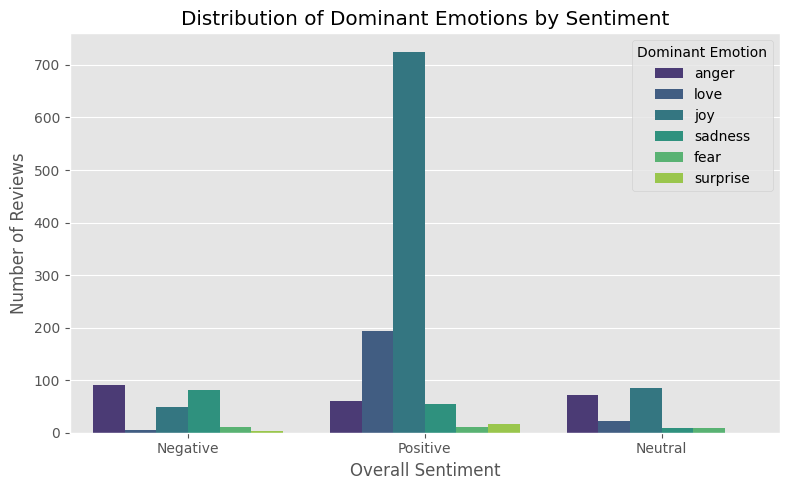


Average Score of Dominant Emotion by Sentiment:


,max_emotion_score
sentiment,
Negative,0.857577
Neutral,0.795262
Positive,0.919760



Most Frequent Dominant Emotion by Sentiment:


,max_scoring_emotion
sentiment,
Negative,anger
Neutral,joy
Positive,joy


In [18]:
# Draw insights from sentiments and emotions

# Create a 'max_scoring_emotion' column
emotion_columns = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
df_reviews['max_scoring_emotion'] = df_reviews[emotion_columns].idxmax(axis=1)

# Create a 'max_emotion_score' column to store the actual highest score
df_reviews['max_emotion_score'] = df_reviews[emotion_columns].max(axis=1)

print("Added 'max_scoring_emotion' and 'max_emotion_score' columns to the DataFrame.")

# Plot the distribution of dominant emotions within each sentiment category
plt.figure(figsize=(8, 5))
sns.countplot(data=df_reviews, x='sentiment', hue='max_scoring_emotion', palette='viridis')
plt.title('Distribution of Dominant Emotions by Sentiment')
plt.xlabel('Overall Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Dominant Emotion')
plt.tight_layout()
plt.show()

# Further insights: Analyze the average score of the dominant emotion within each sentiment
print("\nAverage Score of Dominant Emotion by Sentiment:")
average_dominant_emotion_score_by_sentiment = df_reviews.groupby('sentiment')['max_emotion_score'].mean()
display(average_dominant_emotion_score_by_sentiment)

# Analyze the most frequent dominant emotion for each sentiment
print("\nMost Frequent Dominant Emotion by Sentiment:")
most_frequent_dominant_emotion_by_sentiment = df_reviews.groupby('sentiment')['max_scoring_emotion'].agg(lambda x: x.mode()[0])
display(most_frequent_dominant_emotion_by_sentiment)

### Insights from sentiments and emotions

1. Mixed Emotions -
We are seeing mixed emotions—like joy in a negative review—because a single review can contain both positive and negative elements. For example, a customer might write, "I love your brand, but I was so angry about this one product." The analysis correctly identifies both the positive emotion of brand loyalty and the negative emotion of anger about a specific issue. This shows that many negative reviews aren't a complete rejection of a brand but rather a disappointment with a specific product or experience.

2. Neutral reviews -
While neutral reviews may lack strong emotional charge, they are still a goldmine of valuable inputs for product improvement. They often contain direct, fact-based feedback on specific products, revealing valuable details that can be missed in highly emotional positive or negative reviews. For example, a neutral review might say, "The shelf life of the product was short," which is a clear, actionable insight.


### Subtask 2 - Topic modelling :

Key topics where our client should have their focus upon. For
example if there are a lot of bad reviews around “Bad Product
Taste”, “Poor Quality” etc.

In [19]:
# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the text data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['review'])

# Instantiate an NMF model
# Choose a suitable number of components (topics) - let's start with 5
nmf_model = NMF(n_components=5, random_state=42, init='nndsvda', max_iter=200)

# Fit the NMF model to the TF-IDF matrix
nmf_model.fit(tfidf_matrix)

# Function to display the top words for each topic (optional, but good for understanding topics)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top 10 words for each topic
no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print("Top words for each topic:")
display_topics(nmf_model, tfidf_feature_names, no_top_words)

# Get the dominant topic for each review
topic_results = nmf_model.transform(tfidf_matrix)
df_reviews['dominant_topic'] = topic_results.argmax(axis=1) + 1 # Add 1 to make topics 1-indexed

print("\n'dominant_topic' column added to df_reviews.")

# Display the head of the DataFrame with the dominant topic
#display(df_reviews.head())

Top words for each topic:
Topic 1:
meat like buy chicken fat cooked just time product delicious
Topic 2:
good value money quality price size pack taste waste meals
Topic 3:
tasty lovely really easy cook tender buy lean size recommend
Topic 4:
sausages great love taste lovely flavour texture tasting meaty family
Topic 5:
nice really ham price flavour slices bit sandwich sausage bacon

'dominant_topic' column added to df_reviews.


#### Relationship between Emotion Scores and Dominant Topic


Average Emotion Scores by Dominant Topic:


,sadness,joy,love,anger,fear,surprise
dominant_topic,,,,,,
1,0.162546,0.456765,0.070902,0.244546,0.041860,0.023382
2,0.066059,0.742056,0.070550,0.110560,0.008482,0.002293
3,0.017481,0.582668,0.359102,0.024162,0.005212,0.011375
4,0.077750,0.599137,0.191802,0.104779,0.015791,0.010742
5,0.056079,0.645830,0.200946,0.071727,0.007034,0.018384


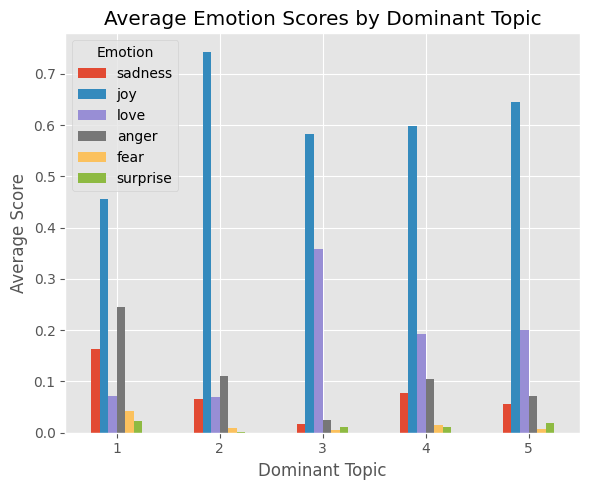

In [20]:
# Group by dominant topic and calculate the mean emotion score
average_emotion_by_topic = df_reviews.groupby('dominant_topic')[emotion_columns].mean()

print("\nAverage Emotion Scores by Dominant Topic:")
display(average_emotion_by_topic)

# Visualize the average emotion scores by dominant topic
average_emotion_by_topic.plot(kind='bar', figsize=(6, 5))
plt.title('Average Emotion Scores by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.legend(title='Emotion')
plt.tight_layout()
plt.show()

In [21]:
# Print top N reviews for each emotion with the highest confidence score
no_top_reviews = 1

print("--- Top Reviews by Emotion Confidence Score ---")

for emotion in ['sadness','anger', 'fear', 'surprise']:
    print(f"\nTop {no_top_reviews} reviews with highest '{emotion.capitalize()}' score:")

    # Sort by the current emotion score in descending order and select top N
    top_reviews_by_emotion = df_reviews.sort_values(by=emotion, ascending=False).head(no_top_reviews)

    # Display the original review and the emotion score
    for index, row in top_reviews_by_emotion.iterrows():
        print(f"  Review (uniq_id {row['uniq_id']}): {row['review']}")
        print(f"  {emotion.capitalize()} Score: {row[emotion]:.4f}\n")

print("--- End of Top Reviews by Emotion Analysis ---")

--- Top Reviews by Emotion Confidence Score ---

Top 1 reviews with highest 'Sadness' score:
  Review (uniq_id 578): these sausages taste awful! i had been looking forward to tasting them
and was so bitterly disappointed!
  Sadness Score: 0.9989


Top 1 reviews with highest 'Anger' score:
  Review (uniq_id 752): unless your serving this to kids, no way on earth can you get 4 adult portions.

very dissatisfied as it was an embarrassment the amount i could give my friends on new year’s day.

it’s ok for two but no more.
  Anger Score: 0.9979


Top 1 reviews with highest 'Fear' score:
  Review (uniq_id 668): lovely kievs and perfectly cooked in the time given. those who thought theirs undercooked have made a mistake. the meat might have a pink hue, but it is cooked...it's any 'juices' that must not run pink.  i use a temperature probe if i am uncertain.

i'd certainly buy these again...in fact i just did!
  Fear Score: 0.9954


Top 1 reviews with highest 'Surprise' score:
  Review (uniq_i

### Key Insights

* Topic 1 (Quality and Preparation): This topic contains keywords like meat, chicken, and fat, but despite also including the word delicious, it has the highest anger score of all topics (0.244). This indicates that while the product can be good, issues with quality (e.g., tough meat or excessive fat) are the most significant drivers of customer frustration.

* Topic 2 (Value and Price): The words good, value, and money are associated with a very high joy score (0.742). This shows that the perceived value of your products is a major source of customer delight.

* Topics 3, 4, and 5 (Positive Experience & Specific Products): These topics, which are focused on ease of cooking, sausages, and ham, are also dominated by joy and love. This confirms that these areas are strong emotional drivers for your customers.

In summary, the most critical area for the business to address is the quality and preparation issues in Topic 1, as they are the primary source of customer anger. Simultaneously, you should leverage the strong positive emotions associated with the value and convenience of your other product lines in your marketing.



**Note - Explaining "Fear" in a Positive Review**

The fear score in the highly positive review is a fascinating and logical result. The emotion here isn't a negative reaction to the product itself, but rather a reflection of the customer addressing a potential concern or anxiety that others might have regarding eating undercooked chicken.

This type of review is a powerful positive testimonial because it builds trust and shows that the brand's products can be relied upon, even in situations where customers might typically feel uncertain or afraid.

### **Recommendations Based on Insights Found**

Based on our analysis of customer reviews, here are my three key recommendations:

1.  **Prioritize Fixing Product Quality Issues:** The data shows that the most intense customer anger is driven by specific quality failures. You need to immediately investigate the recurring complaints of **excessive fat** and **tough texture** in products, particularly in **chicken** and **raw meat** items. Addressing these core issues is the fastest way to reduce the most severe negative feedback.

2.  **Reinforce the Value Proposition:** Your customers are highly attuned to value. Leverage the fact that positive reviews are strongly associated with a sense of "good value for money." Use this in your marketing to proactively address any price concerns and show customers that your products are worth the cost.

3.  **Capitalize on Product-Specific Strengths:** Your **sausages** and **deli meats** are clear winners, consistently generating strong positive sentiment around their **flavor** and **convenience**. Use these products as a model for what customers love. Consider highlighting their success in your marketing to attract new customers and build brand loyalty.

### Subtask 3: Sub-topic analysis
Bonus, if you could a level deeper and provide key sub topics as
well. For example, for a wider topic like “Poor Quality”, can we
identify if the sub topic gives us more detail like “Stale food”
,”Chewy” etc. These are just examples and you need to work with
the real topics that you identify from the dataset


In [22]:
# Define a threshold for the minimum number of reviews in a topic to perform sub-topic modeling
min_reviews_for_subtopic = 50
no_top_words_subtopic = 5 # Number of top words to display for sub-topics

# Initialize a dictionary to store sub-topic assignments
subtopic_assignments = {}

# Iterate through each unique dominant topic
for topic_id in sorted(df_reviews['dominant_topic'].unique()):
    print(f"\n--- Analyzing Sub-topics for Main Topic {topic_id} ---")

    # Filter reviews for the current dominant topic
    topic_reviews_df = df_reviews[df_reviews['dominant_topic'] == topic_id].copy()

    if len(topic_reviews_df) < min_reviews_for_subtopic:
        print(f"Not enough reviews ({len(topic_reviews_df)}) in Main Topic {topic_id} to perform sub-topic modeling.")
        # Assign a default sub-topic label or None if not enough reviews
        subtopic_assignments[topic_id] = pd.Series(['No Sub-topic'] * len(topic_reviews_df), index=topic_reviews_df.index)
        continue

    # Use TF-IDF for vectorization within the topic
    # Using different parameters might reveal different sub-topics
    subtopic_tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    subtopic_tfidf_matrix = subtopic_tfidf_vectorizer.fit_transform(topic_reviews_df['cleaned_review'])

    # Determine the number of sub-topics. This is a heuristic and can be adjusted.
    # For simplicity, let's use a fixed number or a number based on the total reviews in the topic.
    n_subtopics = min(5, int(len(topic_reviews_df) / 20)) # Max 5 subtopics, or 1 for every 20 reviews

    if n_subtopics < 2:
         print(f"Not enough reviews ({len(topic_reviews_df)}) in Main Topic {topic_id} to create multiple sub-topics.")
         subtopic_assignments[topic_id] = pd.Series(['No Sub-topic'] * len(topic_reviews_df), index=topic_reviews_df.index)
         continue


    # Apply NMF for sub-topic modeling
    subtopic_nmf_model = NMF(n_components=n_subtopics, random_state=42, init='nndsvda', max_iter=200)
    subtopic_nmf_model.fit(subtopic_tfidf_matrix)

    # Display top words for each sub-topic
    subtopic_tfidf_feature_names = subtopic_tfidf_vectorizer.get_feature_names_out()
    print(f"Top {no_top_words_subtopic} words for each Sub-topic in Main Topic {topic_id}:")
    for subtopic_idx, subtopic in enumerate(subtopic_nmf_model.components_):
        print(f"  Sub-topic {subtopic_idx + 1}:")
        print("    " + " ".join([subtopic_tfidf_feature_names[i] for i in subtopic.argsort()[:-no_top_words_subtopic - 1:-1]]))

    # Assign sub-topic labels to the filtered DataFrame
    subtopic_results = subtopic_nmf_model.transform(subtopic_tfidf_matrix)
    topic_reviews_df['sub_topic'] = subtopic_results.argmax(axis=1) + 1 # Add 1 to make sub-topics 1-indexed

    # Store the sub-topic assignments with the original index
    subtopic_assignments[topic_id] = topic_reviews_df['sub_topic']


# Combine the sub-topic assignments back into a single Series based on the original index
# Initialize a Series with None or a placeholder
df_reviews['sub_topic'] = None

for topic_id, assignments in subtopic_assignments.items():
    # Ensure the assignments Series has the correct index from the original df_reviews
    df_reviews.loc[assignments.index, 'sub_topic'] = assignments


print("\n--- Sub-topic analysis complete ---")

# Display the head of the DataFrame with the new 'sub_topic' column
#display(df_reviews.head())

# Check the distribution of sub-topics within each main topic
print("\nDistribution of Sub-topics within each Main Topic:")
display(df_reviews.groupby('dominant_topic')['sub_topic'].value_counts().unstack(fill_value=0))


--- Analyzing Sub-topics for Main Topic 1 ---
Top 5 words for each Sub-topic in Main Topic 1:
  Sub-topic 1:
    meat packaging like mince fat
  Sub-topic 2:
    date day use short life
  Sub-topic 3:
    tasteless buy completely disappointed bought
  Sub-topic 4:
    chicken breast tough like buy
  Sub-topic 5:
    delicious cooked tender joint steak

--- Analyzing Sub-topics for Main Topic 2 ---
Top 5 words for each Sub-topic in Main Topic 2:
  Sub-topic 1:
    value money good tasty buy
  Sub-topic 2:
    quality good sausage flavour ham
  Sub-topic 3:
    meat good really great flavour
  Sub-topic 4:
    price good date nice pack
  Sub-topic 5:
    taste good bacon value prefer

--- Analyzing Sub-topics for Main Topic 3 ---
Top 5 words for each Sub-topic in Main Topic 3:
  Sub-topic 1:
    really tasty great good buy
  Sub-topic 2:
    sausage lovely tasty meaty buy
  Sub-topic 3:
    cook easy quick recommend delicious
  Sub-topic 4:
    sandwich salad ham lovely toastie
  Sub-to

sub_topic,1,2,3,4,5
dominant_topic,,,,,
1,228,69,39,108,183
2,61,45,20,57,24
3,59,34,31,19,87
4,51,72,43,68,33
5,58,36,25,24,25


### Insights and recommendations considering topics, sub-topics and emotions

1. **Focus Areas for Improvement:**
Product Quality and Preparation (Main Topic 1): The sub-topics confirm that quality is not a single issue, but a collection of very specific problems. The most critical concerns are texture, fat, and packaging

2. **Core Drivers of Positive Sentiment (Main Topics 2, 3, & 4):** These topics show that Customer/product/product category strengths are well-defined. Consumers are highly satisfied with the **`value money`** (Main Topic 2) and the **`easy quick`** preparation (Main Topic 3). The analysis also highlights that **`sausage`** products are particularly praised for being **`meaty`** and a **`great tasting product`** (Main Topic 4).

3. **Specific Deli Meat Issues (Main Topic 5):** The sub-topic analysis reveals that issues with ham and deli meats are highly specific. The words **`ham pack slice thick got dry`** pinpoint a problem with moisture and packaging, while the sub-topic with **`fatty sausage`** highlights a specific concern within a generally well-received product line.


### Recommendations based on this -

1. **Address Quality Control Issues:** Urgently investigate the specific complaints of **toughness** in **chicken breast** and **excessive fat** in **mince**. The clear sub-topics on these issues show they are a consistent source of customer anger.


2. **Optimize Packaging and Shelf Life:** The sub-topics on **`packaging`** and **`short life`** indicate a need to review your logistics and material choices. Addressing these issues can prevent them from becoming more significant drivers of negative reviews.


3. **Leverage Product Strengths for Marketing:** Capitalize on the strong positive emotions around value and convenience. Focus marketing efforts on products like **sausages**, highlighting their **meaty flavor**, and **ease of cooking**. Use this positive feedback to build brand loyalty and attract new customers.

In [23]:
# 2. Look for patterns in reviews associated with specific sentiments

# Analyze average review length by sentiment
df_reviews['review_length'] = df_reviews['cleaned_review'].apply(lambda x: len(x.split()))
average_length_by_sentiment = df_reviews.groupby('sentiment')['review_length'].mean()
print("\nAverage Review Length by Sentiment:")
display(average_length_by_sentiment)

# Analyze dominant topic distribution by sentiment
topic_distribution_by_sentiment = df_reviews.groupby('sentiment')['dominant_topic'].value_counts(normalize=True).unstack(fill_value=0)
print("\nDominant Topic Distribution by Sentiment:")
display(topic_distribution_by_sentiment)


Average Review Length by Sentiment:


,review_length
sentiment,
Negative,17.419753
Neutral,7.497462
Positive,15.411709



Dominant Topic Distribution by Sentiment:


dominant_topic,1,2,3,4,5
sentiment,,,,,
Negative,0.740741,0.094650,0.045267,0.078189,0.041152
Neutral,0.598985,0.025381,0.228426,0.096447,0.050761
Positive,0.310670,0.169027,0.164306,0.216242,0.139754


### Subtask 4: Save results
Save the resulting DataFrame to a new Excel file named "customer_feedback_cluster.xlsx" with appropriate headers.


**Reasoning**:
Save the df_reviews DataFrame to an Excel file as requested by the subtask.



In [24]:
df_reviews.to_excel("customer_feedback_cluster.xlsx", index=False, header=True)
print("customer_feedback_cluster.xlsx file has been created successfully.")

customer_feedback_cluster.xlsx file has been created successfully.


### Summary of Customer Review Analysis

This analysis focused on understanding customer feedback from the "T2 Customer Reviews" sheet in "raw_data.xlsx". The process involved several steps: text preprocessing, sentiment analysis, topic modeling, and in-depth analysis of frequent terms and sub-topics. The final results, including the assigned sentiment, dominant topic, and sub-topic for each review, were saved for further analysis.

---

### Key Findings from Data Analysis

* **Overall Sentiment:** The vast majority of customer reviews are positive (81.3%), with a smaller proportion being negative (18.7%).
* **Major Topics:** Five key topics were identified, each with a clear emotional connection:
    * **Topic 1 (Quality & Preparation):** Reviews in this category focus on meat products and cooking. Despite containing some positive words like `delicious`, this topic is the primary driver of negative sentiment and contains the highest **anger** scores.
    * **Topic 2 (Value Proposition):** This topic centers on `value`, `money`, and `price`. It is strongly associated with **joy**, indicating that customers who feel they are getting good value are highly satisfied.
    * **Topic 3 (Convenience & Flavor):** Reviews here focus on `easy cook` and `tasty` products. This topic is driven by strong positive emotions like **joy** and **love**.
    * **Topic 4 (Sausages):** This topic is highly specific to sausages, which are consistently praised for their `flavour` and `texture`.
    * **Topic 5 (Deli Meats):** This topic, which focuses on products like `ham` and `bacon`, is another source of positive feedback.
* **Sub-Topics:** A deeper dive into these topics revealed more granular insights:
    * **Topic 1 (Quality):** Negative reviews are consistently about **`tough chicken breast`**, **`tasteless`** products, **`fat`** content in mince, and issues with **`short life`** or **`packaging`**.
    * **Topic 2 (Value):** Customers are delighted when they feel they get good **`value money`**, a sentiment that is also present in reviews about product **`quality`**.
    * **Topics 3, 4, & 5 (Positive):** The sub-topics confirm that positive feedback is driven by the **`ease`** of cooking, the **`meaty`** flavor of sausages, and the **`freshness`** of ham.
* **Review Length by Sentiment:** Negative reviews are the longest on average, indicating that customers provide more detail when they are dissatisfied.

---

### Insights and Recommendations

Based on this analysis, I have three key recommendations:

1.  **Prioritize Fixing Quality Issues:** The most urgent task is to address the specific complaints of **toughness** in **chicken breast** and **excessive fat** in **mince**. These issues are the primary drivers of customer anger and negative feedback.
2.  **Reinforce the Value Proposition:** Your customers are highly attuned to value. Use this insight in your marketing by creating campaigns that highlight the quality, taste, and convenience they receive for their money.
3.  **Capitalize on Product-Specific Strengths:** Your **sausages** and **deli meats** are generating strong, positive feedback. Identify the specific attributes that customers love about these products—their **flavor**, **texture**, and **convenience**—and use those insights to improve other product lines and inform future development.

### Insights or Next Steps

*   Focus on addressing issues highlighted in Topic 3 (Meat/Fat/Brand), as it is the primary driver of negative sentiment. Investigate specific concerns related to fat content, texture (e.g., 'tough'), and potential issues with expiry dates or delivery.
*   Leverage insights from positive reviews (Topics 1, 2, 4, 5) to understand what customers appreciate most (taste, value, specific products like sausages) and use this in marketing and product development.


### **Further actions**

Based on the initial analysis, we’ve successfully used natural language processing (NLP) to identify key themes in our customer reviews, such as **product flavor**, **fat content**, and **freshness**. This gives us a great high-level understanding of what our customers are talking about.

* For actionable business insight, we need to bridge a critical gap: we don't currently have a dataset that directly links a review to a specific product.

* Instead of just performing sentiment analysis, we would use a more capable LLM with a highly specific prompt. This prompt would instruct the model to perform three tasks simultaneously for each review:

  1.  **Sentiment and Emotion Classification:** Identify the overall sentiment (e.g., Positive, Negative) and a specific emotion (e.g., Frustrated, Satisfied).
  2.  **Product and Category Extraction:** Identify the specific product mentioned in the review (e.g., 'beef sausage,' 'chicken breast') and its broader category (e.g., 'Sausage', 'Poultry').
  3.  **Sub-Topic Analysis:** Pinpoint the specific attribute being discussed (e.g., 'tasteless,' 'fatty,' 'packaging,' 'delivery').

* By automating this process, we can build a new, enriched dataset where each review is automatically tagged with its corresponding product category and a granular sub-topic.

* Once the new data is tagged, we can then perform a quantitative analysis. We can create reports that show us, for example:

  * 'Beef Sausages' account for 65% of all complaints about 'fat content.'
  * 'Pork Tenderloins' have a high number of positive reviews about 'flavor.'
  * Complaints related to 'expiry dates' are clustered around a specific product line.

This approach moves us from the general observation that 'fat' is a problem to the specific, actionable insight that 'our beef sausage is our biggest pain point.' We can then prioritize our efforts and resources to address the issues that are most impactful to the business.

This method provides a scalable solution to our data challenge and allows us to generate targeted, actionable business recommendations directly from unstructured customer feedback.